In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.3/901.3 kB 15.1 MB/s eta 0:00:00


In [ ]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 44.7 MB/s eta 0:00:00


In [ ]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 3.9 MB/s eta 0:00:00


In [ ]:
import torch
import transformers
import pytorch_lightning
import zipfile
import os
import shutil
import pandas as pd
import torch
from PIL import Image
import torchvision
import random
import cv2
import numpy as np
import supervision as sv
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from torchvision.ops import box_convert, batched_nms
from tqdm.notebook import tqdm
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import copy
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
def extract_zip(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [ ]:
dataset_path = '/content/drive/My Drive/MURA-v1.1.zip'
extract_path = '/content/'
extract_zip(dataset_path,extract_path)

In [ ]:
# Define the mapping for 'class'
class_mapping = {
    'XR_ELBOW': 0,
    'XR_FINGER': 1,
    'XR_FOREARM': 2,
    'XR_HAND': 3,
    'XR_HUMERUS': 4,
    'XR_SHOULDER': 5,
    'XR_WRIST': 6
}

In [ ]:
import pandas as pd


df = pd.read_csv('/content/MURA-v1.1/train_image_paths.csv', header=None, names=['path'])

# Add the 'fractured' column (1 for 'positive', 0 for 'negative')
df['fractured'] = df['path'].apply(lambda x: 1 if 'positive' in x else 0)



# Add the 'class' column based on the study type in the path
df['class'] = df['path'].apply(lambda x: class_mapping[x.split('/')[2]])


df.to_csv('processed_data_train.csv', index=False)




In [ ]:
print(df[10000:12000])

                                                    path  fractured  class
10000  MURA-v1.1/train/XR_FINGER/patient03319/study1_...          1      1
10001  MURA-v1.1/train/XR_FINGER/patient03319/study1_...          1      1
10002  MURA-v1.1/train/XR_FINGER/patient03319/study1_...          1      1
10003  MURA-v1.1/train/XR_FINGER/patient01380/study1_...          1      1
10004  MURA-v1.1/train/XR_FINGER/patient01380/study1_...          1      1
...                                                  ...        ...    ...
11995  MURA-v1.1/train/XR_FINGER/patient03917/study1_...          0      1
11996  MURA-v1.1/train/XR_FINGER/patient03917/study1_...          0      1
11997  MURA-v1.1/train/XR_FINGER/patient03917/study1_...          0      1
11998  MURA-v1.1/train/XR_FINGER/patient03918/study1_...          0      1
11999  MURA-v1.1/train/XR_FINGER/patient03918/study1_...          0      1

[2000 rows x 3 columns]


In [ ]:

df_val = pd.read_csv('/content/MURA-v1.1/valid_image_paths.csv', header=None, names=['path'])

# Add the 'fractured' column (1 for 'positive', 0 for 'negative')
df_val['fractured'] = df_val['path'].apply(lambda x: 1 if 'positive' in x else 0)
df_val['class'] = df_val['path'].apply(lambda x: class_mapping[x.split('/')[2]])


df_val.to_csv('processed_data_valid.csv', index=False)

In [ ]:
albumentations_transform = A.Compose([
    A.Blur(p=0.1, blur_limit=(3, 7)),
    A.MedianBlur(p=0.1, blur_limit=(3, 7)),
    A.ToGray(p=0.1, method='weighted_average'),
    A.CLAHE(p=0.1, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8)),
    A.Rotate(limit=(-30, 30), p=0.3),
    A.HorizontalFlip(p=0.3),
    A.Resize(640, 640),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [ ]:
albumentations_transform_val = A.Compose([
    A.Resize(640, 640),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [ ]:
class FracturedDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # Get the row corresponding to the index
        row = self.data.iloc[idx]

        # Load the image
        image_path = row['path']
        image = Image.open(image_path).convert("RGB")
        image = np.array(image)


        if self.transform:

            transformed = self.transform(image=image)
            image = transformed['image']

        # Get the labels
        fractured = row['fractured']
        #class_label = row['class']


        return image, fractured

In [ ]:
seed_everything(42)
train_dataset = FracturedDataset(csv_file="processed_data_train.csv", transform=albumentations_transform)
val_dataset = FracturedDataset(csv_file="processed_data_valid.csv", transform = albumentations_transform_val)



In [ ]:
sample, label = train_dataset[19]
#print(sample)

In [ ]:
print(label)

0


In [ ]:
# Create DataLoader
seed_everything(42)
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=8,
    pin_memory=True
)

valid_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=8,
    pin_memory=True
)

In [ ]:
from ultralytics import YOLO

# Load the YOLOv11 model
model = YOLO("yolo11s.pt")



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 18.4M/18.4M [00:00<00:00, 154MB/s]


In [ ]:
backbone = copy.deepcopy(model.model.model[:9])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Model(nn.Module):
    def __init__(self, backbone):
        super(Model, self).__init__()
        self.backbone = backbone
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # Reduce [512, 20, 20] to [512, 1, 1]
        self.fc1 = nn.Linear(512,128)
        self.dropout = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.backbone(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)  # to [batch_size, 512]
        x = self.fc1(x)
        x= self.dropout(x)
        x = self.fc2(x)
        return x


mymodel = Model(backbone)

In [ ]:
for param in mymodel.parameters():
  param.requires_grad = True

In [ ]:
trainable_params = []
non_trainable_params = []

for name, param in mymodel.named_parameters():
    if param.requires_grad:
        trainable_params.append((name, param.size()))
    else:
        non_trainable_params.append((name, param.size()))


print("Trainable Parameters:")
for name, size in trainable_params:
    print(f"{name}: {size}")


print("\nNon-Trainable Parameters:")
for name, size in non_trainable_params:
    print(f"{name}: {size}")

Trainable Parameters:
backbone.0.conv.weight: torch.Size([32, 3, 3, 3])
backbone.0.bn.weight: torch.Size([32])
backbone.0.bn.bias: torch.Size([32])
backbone.1.conv.weight: torch.Size([64, 32, 3, 3])
backbone.1.bn.weight: torch.Size([64])
backbone.1.bn.bias: torch.Size([64])
backbone.2.cv1.conv.weight: torch.Size([64, 64, 1, 1])
backbone.2.cv1.bn.weight: torch.Size([64])
backbone.2.cv1.bn.bias: torch.Size([64])
backbone.2.cv2.conv.weight: torch.Size([128, 96, 1, 1])
backbone.2.cv2.bn.weight: torch.Size([128])
backbone.2.cv2.bn.bias: torch.Size([128])
backbone.2.m.0.cv1.conv.weight: torch.Size([16, 32, 3, 3])
backbone.2.m.0.cv1.bn.weight: torch.Size([16])
backbone.2.m.0.cv1.bn.bias: torch.Size([16])
backbone.2.m.0.cv2.conv.weight: torch.Size([32, 16, 3, 3])
backbone.2.m.0.cv2.bn.weight: torch.Size([32])
backbone.2.m.0.cv2.bn.bias: torch.Size([32])
backbone.3.conv.weight: torch.Size([128, 128, 3, 3])
backbone.3.bn.weight: torch.Size([128])
backbone.3.bn.bias: torch.Size([128])
backbone.4.

In [ ]:
learning_rate = 0.0001
optimizer = torch.optim.AdamW(mymodel.parameters(), lr=learning_rate, weight_decay = 3e-4)
T_max = 12   # Number of epochs for the learning rate decay to reach its minimum
eta_min = 1e-5  # Minimum learning rate

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
criterion = torch.nn.CrossEntropyLoss()

num_epochs = 12

mymodel.to(device)

Model(
  (backbone): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (

In [ ]:
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
train_f1_scores = []
valid_f1_scores = []

best_model = copy.deepcopy(mymodel.state_dict())
highest_val_acc = 0


In [ ]:
seed_everything(42)
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 10)

    mymodel.train()
    total_train_loss = 0
    total_val_loss = 0
    total_train_labels = []
    total_train_preds = []
    total_val_labels = []
    total_val_preds = []

    # Wrap the training DataLoader with tqdm for progress tracking
    train_loader_tqdm = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", leave=False)

    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mymodel(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)

        total_train_labels.extend(labels.cpu().numpy())
        total_train_preds.extend(preds.cpu().numpy())
        total_train_loss += loss.item() * images.size(0) # batch_size

        # Update tqdm with current loss
        train_loader_tqdm.set_postfix(loss=loss.item())

    epoch_train_loss = total_train_loss / len(train_loader.dataset)
    epoch_train_acc = accuracy_score(total_train_labels, total_train_preds)
    epoch_train_f1 = f1_score(total_train_labels, total_train_preds, average = "weighted")

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    train_f1_scores.append(epoch_train_f1)

    #Validation step
    mymodel.eval()
    with torch.no_grad():
      val_loader_tqdm = tqdm(valid_loader, desc=f"Validation Epoch {epoch + 1}", leave=False)
      for images, labels in val_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        outputs = mymodel(images)
        val_loss = criterion(outputs,labels)
        _, preds = torch.max(outputs,1)

        total_val_loss += val_loss * images.size(0)
        total_val_labels.extend(labels.cpu().numpy())
        total_val_preds.extend(preds.cpu().numpy())
        val_loader_tqdm.set_postfix(loss=val_loss.item())
    epoch_val_loss = total_val_loss / len(valid_loader.dataset)
    epoch_val_acc = accuracy_score(total_val_labels, total_val_preds)
    epoch_val_f1 = f1_score(total_val_labels, total_val_preds, average = "weighted")

    valid_losses.append(epoch_val_loss)
    valid_accuracies.append(epoch_val_acc)
    valid_f1_scores.append(epoch_val_f1)

    print(f"Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")
    print(f"Training Accuracy: {epoch_train_acc:.4f}, Validation Accuracy: {epoch_val_acc:.4f}")
    print(f"Training F1 Score: {epoch_train_f1:.4f}, Validation F1 Score: {epoch_val_f1:.4f}")

    if epoch_val_acc > highest_val_acc:
        highest_val_acc = epoch_val_acc
        torch.save(mymodel.backbone.state_dict(), f'/content/drive/MyDrive/mura_backbone_weights_epoch{epoch}.pth')
        best_model = copy.deepcopy(mymodel.state_dict())

        print("Saving the best model so far with validation accuracy:", highest_val_acc)

    scheduler.step()
    # Print learning rate for monitoring
    lr = optimizer.param_groups[0]['lr']
    print(f" Learning Rate: {lr}")
    print('')

Epoch 1/12
----------


Training Epoch 1:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss: 0.5179, Validation Loss: 0.5095
Training Accuracy: 0.7505, Validation Accuracy: 0.7717
Training F1 Score: 0.7425, Validation F1 Score: 0.7675
Saving the best model so far with validation accuracy: 0.7716609321238661
 Learning Rate: 9.846666218300807e-05

Epoch 2/12
----------


Training Epoch 2:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss: 0.4620, Validation Loss: 0.4896
Training Accuracy: 0.7952, Validation Accuracy: 0.7632
Training F1 Score: 0.7904, Validation F1 Score: 0.7537
 Learning Rate: 9.397114317029975e-05

Epoch 3/12
----------


Training Epoch 3:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss: 0.4372, Validation Loss: 0.4821
Training Accuracy: 0.8104, Validation Accuracy: 0.7917
Training F1 Score: 0.8063, Validation F1 Score: 0.7916
Saving the best model so far with validation accuracy: 0.7916796997184861
 Learning Rate: 8.681980515339464e-05

Epoch 4/12
----------


Training Epoch 4:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss: 0.4176, Validation Loss: 0.4978
Training Accuracy: 0.8196, Validation Accuracy: 0.7735
Training F1 Score: 0.8163, Validation F1 Score: 0.7645
 Learning Rate: 7.75e-05

Epoch 5/12
----------


Training Epoch 5:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 5:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss: 0.3960, Validation Loss: 0.4361
Training Accuracy: 0.8311, Validation Accuracy: 0.8108
Training F1 Score: 0.8284, Validation F1 Score: 0.8104
Saving the best model so far with validation accuracy: 0.8107600875821083
 Learning Rate: 6.664685702961344e-05

Epoch 6/12
----------


Training Epoch 6:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 6:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss: 0.3749, Validation Loss: 0.4592
Training Accuracy: 0.8407, Validation Accuracy: 0.7932
Training F1 Score: 0.8383, Validation F1 Score: 0.7929
 Learning Rate: 5.5e-05

Epoch 7/12
----------


Training Epoch 7:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 7:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss: 0.3516, Validation Loss: 0.4752
Training Accuracy: 0.8543, Validation Accuracy: 0.8129
Training F1 Score: 0.8526, Validation F1 Score: 0.8095
Saving the best model so far with validation accuracy: 0.8129496402877698
 Learning Rate: 4.335314297038657e-05

Epoch 8/12
----------


Training Epoch 8:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 8:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss: 0.3279, Validation Loss: 0.5074
Training Accuracy: 0.8639, Validation Accuracy: 0.7973
Training F1 Score: 0.8625, Validation F1 Score: 0.7957
 Learning Rate: 3.250000000000001e-05

Epoch 9/12
----------


Training Epoch 9:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 9:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss: 0.2972, Validation Loss: 0.4770
Training Accuracy: 0.8788, Validation Accuracy: 0.8079
Training F1 Score: 0.8778, Validation F1 Score: 0.8075
 Learning Rate: 2.3180194846605367e-05

Epoch 10/12
----------


Training Epoch 10:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 10:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss: 0.2693, Validation Loss: 0.5073
Training Accuracy: 0.8916, Validation Accuracy: 0.8151
Training F1 Score: 0.8909, Validation F1 Score: 0.8133
Saving the best model so far with validation accuracy: 0.8151391929934313
 Learning Rate: 1.602885682970026e-05

Epoch 11/12
----------


Training Epoch 11:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 11:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss: 0.2487, Validation Loss: 0.5239
Training Accuracy: 0.9018, Validation Accuracy: 0.8164
Training F1 Score: 0.9012, Validation F1 Score: 0.8151
Saving the best model so far with validation accuracy: 0.8163903659680951
 Learning Rate: 1.1533337816991932e-05

Epoch 12/12
----------


Training Epoch 12:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 12:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss: 0.2331, Validation Loss: 0.5417
Training Accuracy: 0.9081, Validation Accuracy: 0.8211
Training F1 Score: 0.9076, Validation F1 Score: 0.8199
Saving the best model so far with validation accuracy: 0.8210822646230841
 Learning Rate: 1e-05



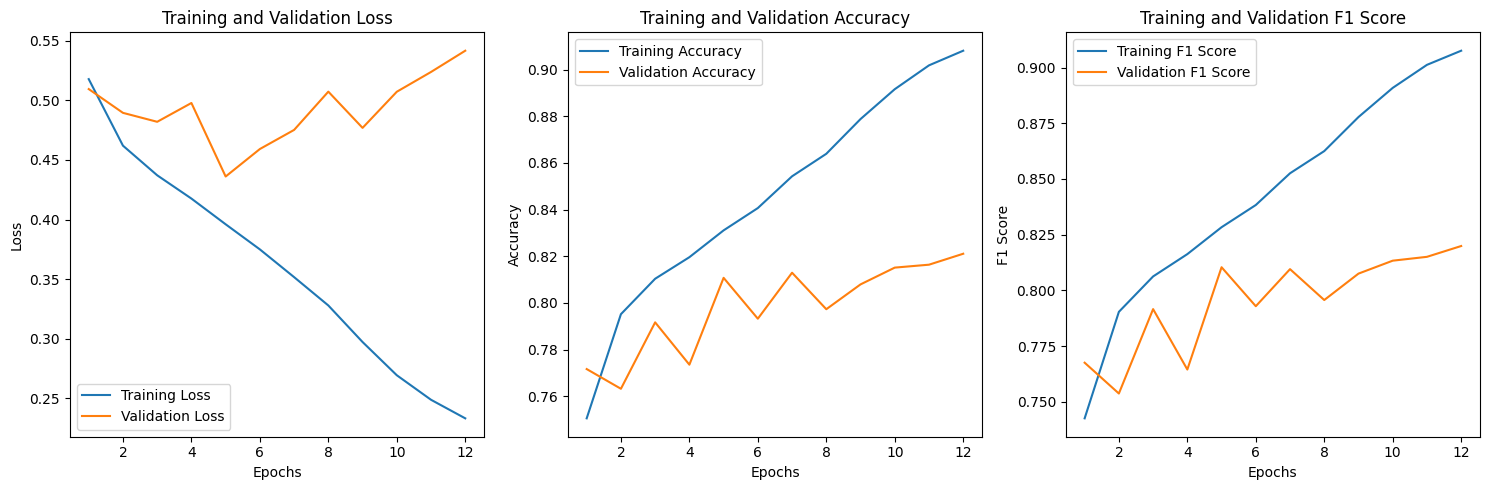

In [ ]:
epochs = np.arange(1, num_epochs + 1)
train_losses = [loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
valid_losses = [loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in valid_losses]
train_accuracies = [acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in train_accuracies]
valid_accuracies = [acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in valid_accuracies]
train_f1_scores = [f1.cpu().numpy() if isinstance(f1, torch.Tensor) else f1 for f1 in train_f1_scores]
valid_f1_scores = [f1.cpu().numpy() if isinstance(f1, torch.Tensor) else f1 for f1 in valid_f1_scores]
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, valid_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, label="Training Accuracy")
plt.plot(epochs, valid_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1, 3, 3)
plt.plot(epochs, train_f1_scores, label="Training F1 Score")
plt.plot(epochs, valid_f1_scores, label="Validation F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()
plt.title("Training and Validation F1 Score")

plt.tight_layout()
plt.show()

#Train on second task to predict the class (elbow, humerus etc.) and fractured or non fractured


In [ ]:
class FracturedDataset2(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # Get the row corresponding to the index
        row = self.data.iloc[idx]


        image_path = row['path']
        image = Image.open(image_path).convert("RGB")
        image = np.array(image)


        if self.transform:

            transformed = self.transform(image=image)
            image = transformed['image']

        # Get the labels
        fractured = row['fractured']
        class_label = row['class']


        return image, fractured, class_label

In [ ]:
seed_everything(42)
train_dataset = FracturedDataset2(csv_file="processed_data_train.csv", transform=albumentations_transform)
val_dataset = FracturedDataset2(csv_file="processed_data_valid.csv", transform = albumentations_transform_val)

In [ ]:
# Create DataLoader
seed_everything(42)
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=8,
    pin_memory=True
)

valid_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=8,
    pin_memory=True
)

In [ ]:
class Model2(nn.Module):
    def __init__(self, backbone):
        super(Model2, self).__init__()
        self.backbone = backbone
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  #  [512, H, W] to [512, 1, 1]
        self.flatten = nn.Flatten()
        self.shared_fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.GELU(),
            nn.Dropout(p=0.4)
        )
        self.fc_fractured = nn.Linear(128, 2)  # Binary classification for fracture detection
        self.fc_class = nn.Linear(128, 7)     # Multi-class classification for body part

    def forward(self, x):
        x = self.backbone(x)
        x = self.global_pool(x)
        x = self.flatten(x)
        x = self.shared_fc(x)
        fractured_out = self.fc_fractured(x)
        class_out = self.fc_class(x)
        return fractured_out, class_out

In [ ]:
backbone = copy.deepcopy(model.model.model[:9])

In [ ]:
mymodel = Model2(backbone)
mymodel.to(device)

Model2(
  (backbone): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      

In [ ]:
for param in mymodel.parameters():
  param.requires_grad = True

In [ ]:
trainable_params = []
non_trainable_params = []

for name, param in mymodel.named_parameters():
    if param.requires_grad:
        trainable_params.append((name, param.size()))
    else:
        non_trainable_params.append((name, param.size()))

# Print trainable parameters
print("Trainable Parameters:")
for name, size in trainable_params:
    print(f"{name}: {size}")

# Print non-trainable parameters
print("\nNon-Trainable Parameters:")
for name, size in non_trainable_params:
    print(f"{name}: {size}")

Trainable Parameters:
backbone.0.conv.weight: torch.Size([32, 3, 3, 3])
backbone.0.bn.weight: torch.Size([32])
backbone.0.bn.bias: torch.Size([32])
backbone.1.conv.weight: torch.Size([64, 32, 3, 3])
backbone.1.bn.weight: torch.Size([64])
backbone.1.bn.bias: torch.Size([64])
backbone.2.cv1.conv.weight: torch.Size([64, 64, 1, 1])
backbone.2.cv1.bn.weight: torch.Size([64])
backbone.2.cv1.bn.bias: torch.Size([64])
backbone.2.cv2.conv.weight: torch.Size([128, 96, 1, 1])
backbone.2.cv2.bn.weight: torch.Size([128])
backbone.2.cv2.bn.bias: torch.Size([128])
backbone.2.m.0.cv1.conv.weight: torch.Size([16, 32, 3, 3])
backbone.2.m.0.cv1.bn.weight: torch.Size([16])
backbone.2.m.0.cv1.bn.bias: torch.Size([16])
backbone.2.m.0.cv2.conv.weight: torch.Size([32, 16, 3, 3])
backbone.2.m.0.cv2.bn.weight: torch.Size([32])
backbone.2.m.0.cv2.bn.bias: torch.Size([32])
backbone.3.conv.weight: torch.Size([128, 128, 3, 3])
backbone.3.bn.weight: torch.Size([128])
backbone.3.bn.bias: torch.Size([128])
backbone.4.

In [ ]:
learning_rate = 0.0001
optimizer = torch.optim.AdamW(mymodel.parameters(), lr=learning_rate, weight_decay = 3e-4)
T_max = 15   # Number of epochs for the learning rate decay to reach its minimum
eta_min = 1e-5  # Minimum learning rate

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
criterion = torch.nn.CrossEntropyLoss()

num_epochs = 15

In [ ]:
criterion_fractured = nn.CrossEntropyLoss()
criterion_class = nn.CrossEntropyLoss()
highest_val_f1 = 0
train_losses = {'fractured': [], 'class': []}
valid_losses = {'fractured': [], 'class': []}
train_metrics = {'accuracy_fractured': [], 'accuracy_class': [], 'f1_fractured': [], 'f1_class': []}
valid_metrics = {'accuracy_fractured': [], 'accuracy_class': [], 'f1_fractured': [], 'f1_class': []}

In [ ]:
seed_everything(42)
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 10)

    mymodel.train()
    total_train_loss = {'fractured': 0.0, 'class':0.0}
    total_val_loss = {'fractured': 0.0, 'class':0.0}
    total_train_labels = {'fractured': [], 'class':[]}
    total_train_preds = {'fractured': [], 'class':[]}
    total_val_labels = {'fractured': [], 'class': []}
    total_val_preds = {'fractured': [], 'class': []}


    train_loader_tqdm = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", leave=False)

    for images, fractured_labels, class_labels in train_loader_tqdm:
        images, fractured_labels, class_labels = images.to(device), fractured_labels.to(device), class_labels.to(device)
        optimizer.zero_grad()
        fractured_out, class_out = mymodel(images)
        loss_fractured = criterion_fractured(fractured_out, fractured_labels)
        loss_class = criterion_class(class_out, class_labels)
        loss = 0.75*loss_fractured + 0.25*loss_class  # Combine losses
        loss.backward()
        optimizer.step()

        _, preds_fractured = torch.max(fractured_out, 1)
        _, preds_class = torch.max(class_out, 1)

        total_train_labels['fractured'].extend(fractured_labels.cpu().numpy())
        total_train_preds['fractured'].extend(preds_fractured.cpu().numpy())
        total_train_labels['class'].extend(class_labels.cpu().numpy())
        total_train_preds['class'].extend(preds_class.cpu().numpy())

        total_train_loss['fractured'] += loss_fractured.item() * images.size(0)
        total_train_loss['class'] += loss_class.item() * images.size(0)

        #total_train_loss += loss.item() * images.size(0) # batch_size

        # Update tqdm with current loss
        train_loader_tqdm.set_postfix(loss=loss.item())

    epoch_train_loss_fractured = total_train_loss['fractured'] / len(train_loader.dataset)
    epoch_train_loss_class = total_train_loss['class'] / len(train_loader.dataset)
    epoch_train_accuracy_fractured = accuracy_score(total_train_labels['fractured'], total_train_preds['fractured'])
    epoch_train_accuracy_class = accuracy_score(total_train_labels['class'], total_train_preds['class'])
    epoch_train_f1_fractured = f1_score(total_train_labels['fractured'], total_train_preds['fractured'], average='weighted')
    epoch_train_f1_class = f1_score(total_train_labels['class'], total_train_preds['class'], average='weighted')

    train_losses['fractured'].append(epoch_train_loss_fractured)
    train_losses['class'].append(epoch_train_loss_class)
    train_metrics['accuracy_fractured'].append(epoch_train_accuracy_fractured)
    train_metrics['accuracy_class'].append(epoch_train_accuracy_class)
    train_metrics['f1_fractured'].append(epoch_train_f1_fractured)
    train_metrics['f1_class'].append(epoch_train_f1_class)


    #Validation step
    mymodel.eval()
    with torch.no_grad():
      val_loader_tqdm = tqdm(valid_loader, desc=f"Validation Epoch {epoch + 1}", leave=False)
      for images, fractured_labels, class_labels in val_loader_tqdm:
          images = images.to(device)
          fractured_labels = fractured_labels.to(device)
          class_labels = class_labels.to(device)

          fractured_out, class_out = mymodel(images)

          loss_fractured = criterion_fractured(fractured_out, fractured_labels)
          loss_class = criterion_class(class_out, class_labels)

          _, preds_fractured = torch.max(fractured_out, 1)
          _, preds_class = torch.max(class_out, 1)

          total_val_labels['fractured'].extend(fractured_labels.cpu().numpy())
          total_val_preds['fractured'].extend(preds_fractured.cpu().numpy())
          total_val_labels['class'].extend(class_labels.cpu().numpy())
          total_val_preds['class'].extend(preds_class.cpu().numpy())

          total_val_loss['fractured'] += loss_fractured.item() * images.size(0)
          total_val_loss['class'] += loss_class.item() * images.size(0)

    epoch_val_loss_fractured = total_val_loss['fractured'] / len(valid_loader.dataset)
    epoch_val_loss_class = total_val_loss['class'] / len(valid_loader.dataset)
    epoch_val_accuracy_fractured = accuracy_score(total_val_labels['fractured'], total_val_preds['fractured'])
    epoch_val_accuracy_class = accuracy_score(total_val_labels['class'], total_val_preds['class'])
    epoch_val_f1_fractured = f1_score(total_val_labels['fractured'], total_val_preds['fractured'], average='weighted')
    epoch_val_f1_class = f1_score(total_val_labels['class'], total_val_preds['class'], average='weighted')

    valid_losses['fractured'].append(epoch_val_loss_fractured)
    valid_losses['class'].append(epoch_val_loss_class)
    valid_metrics['accuracy_fractured'].append(epoch_val_accuracy_fractured)
    valid_metrics['accuracy_class'].append(epoch_val_accuracy_class)
    valid_metrics['f1_fractured'].append(epoch_val_f1_fractured)
    valid_metrics['f1_class'].append(epoch_val_f1_class)

    print(f"Training Loss fractured:{epoch_train_loss_fractured:.4f}, class: {epoch_train_loss_class:.4f}")
    print(f"Validation Loss fractured:{epoch_val_loss_fractured:.4f}, class: {epoch_val_loss_class:.4f}")
    print(f"Training acc fractured:{epoch_train_accuracy_fractured:.4f}, class: {epoch_train_accuracy_class:.4f}")
    print(f"Validation acc fractured:{epoch_val_accuracy_fractured:.4f}, class: {epoch_val_accuracy_class:.4f}")
    print(f"Training f1 fractured:{epoch_train_f1_fractured:.4f}, class: {epoch_train_f1_class:.4f}")
    print(f"Validation f1 fractured:{epoch_val_f1_fractured:.4f}, class: {epoch_val_f1_class:.4f}")


    mean_train_f1 = (epoch_train_f1_fractured + epoch_train_f1_class) / 2
    mean_val_f1 = (epoch_val_f1_fractured + epoch_val_f1_class) / 2
    print(f"Mean Train F1: {mean_train_f1:.4f}, Mean Validation F1: {mean_val_f1:.4f}")
    if mean_val_f1 > highest_val_f1:
        highest_val_f1 = mean_val_f1
        torch.save(mymodel.backbone.state_dict(), f'/content/drive/MyDrive/t2v2mura_backbone_weights_epoch{epoch+1}.pth')
        best_model = copy.deepcopy(mymodel.state_dict())

        print("Saving the best model so far with validation f1:", highest_val_f1)

    scheduler.step()
    # Print learning rate for monitoring
    lr = optimizer.param_groups[0]['lr']
    print(f" Learning Rate: {lr}")
    print('')

Epoch 1/15
----------


Training Epoch 1:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss fractured:0.5328, class: 0.6504
Validation Loss fractured:0.4975, class: 0.4284
Training acc fractured:0.7396, class: 0.8202
Validation acc fractured:0.7554, class: 0.8226
Training f1 fractured:0.7333, class: 0.7912
Validation f1 fractured:0.7521, class: 0.7842
Mean Train F1: 0.7622, Mean Validation F1: 0.7682
Saving the best model so far with validation f1: 0.7681592245448235
 Learning Rate: 9.901664203302126e-05

Epoch 2/15
----------


Training Epoch 2:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss fractured:0.4662, class: 0.2306
Validation Loss fractured:0.4759, class: 0.2728
Training acc fractured:0.7914, class: 0.9346
Validation acc fractured:0.7757, class: 0.9231
Training f1 fractured:0.7869, class: 0.9314
Validation f1 fractured:0.7686, class: 0.9204
Mean Train F1: 0.8591, Mean Validation F1: 0.8445
Saving the best model so far with validation f1: 0.8444713631117124
 Learning Rate: 9.610954559391703e-05

Epoch 3/15
----------


Training Epoch 3:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss fractured:0.4389, class: 0.1564
Validation Loss fractured:0.4435, class: 0.2020
Training acc fractured:0.8102, class: 0.9594
Validation acc fractured:0.8136, class: 0.9437
Training f1 fractured:0.8065, class: 0.9590
Validation f1 fractured:0.8122, class: 0.9422
Mean Train F1: 0.8827, Mean Validation F1: 0.8772
Saving the best model so far with validation f1: 0.8772135039609221
 Learning Rate: 9.140576474687264e-05

Epoch 4/15
----------


Training Epoch 4:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss fractured:0.4171, class: 0.1253
Validation Loss fractured:0.5114, class: 0.1715
Training acc fractured:0.8212, class: 0.9664
Validation acc fractured:0.7754, class: 0.9537
Training f1 fractured:0.8181, class: 0.9662
Validation f1 fractured:0.7671, class: 0.9533
Mean Train F1: 0.8921, Mean Validation F1: 0.8602
 Learning Rate: 8.511087728614862e-05

Epoch 5/15
----------


Training Epoch 5:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 5:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss fractured:0.3961, class: 0.1131
Validation Loss fractured:0.4299, class: 0.1604
Training acc fractured:0.8335, class: 0.9712
Validation acc fractured:0.8211, class: 0.9556
Training f1 fractured:0.8309, class: 0.9710
Validation f1 fractured:0.8203, class: 0.9550
Mean Train F1: 0.9010, Mean Validation F1: 0.8876
Saving the best model so far with validation f1: 0.8876150659071071
 Learning Rate: 7.75e-05

Epoch 6/15
----------


Training Epoch 6:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 6:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss fractured:0.3800, class: 0.1014
Validation Loss fractured:0.4803, class: 0.2092
Training acc fractured:0.8408, class: 0.9742
Validation acc fractured:0.7920, class: 0.9368
Training f1 fractured:0.8385, class: 0.9741
Validation f1 fractured:0.7919, class: 0.9357
Mean Train F1: 0.9063, Mean Validation F1: 0.8638
 Learning Rate: 6.890576474687264e-05

Epoch 7/15
----------


Training Epoch 7:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 7:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss fractured:0.3605, class: 0.0953
Validation Loss fractured:0.4982, class: 0.1777
Training acc fractured:0.8524, class: 0.9752
Validation acc fractured:0.7961, class: 0.9478
Training f1 fractured:0.8505, class: 0.9751
Validation f1 fractured:0.7901, class: 0.9472
Mean Train F1: 0.9128, Mean Validation F1: 0.8686
 Learning Rate: 5.970378084704442e-05

Epoch 8/15
----------


Training Epoch 8:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 8:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss fractured:0.3392, class: 0.0868
Validation Loss fractured:0.4563, class: 0.1304
Training acc fractured:0.8607, class: 0.9769
Validation acc fractured:0.8101, class: 0.9653
Training f1 fractured:0.8592, class: 0.9768
Validation f1 fractured:0.8090, class: 0.9651
Mean Train F1: 0.9180, Mean Validation F1: 0.8870
 Learning Rate: 5.029621915295561e-05

Epoch 9/15
----------


Training Epoch 9:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 9:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss fractured:0.3151, class: 0.0826
Validation Loss fractured:0.4435, class: 0.1413
Training acc fractured:0.8733, class: 0.9786
Validation acc fractured:0.8148, class: 0.9584
Training f1 fractured:0.8721, class: 0.9785
Validation f1 fractured:0.8136, class: 0.9579
Mean Train F1: 0.9253, Mean Validation F1: 0.8858
 Learning Rate: 4.109423525312738e-05

Epoch 10/15
----------


Training Epoch 10:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 10:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss fractured:0.2896, class: 0.0762
Validation Loss fractured:0.4842, class: 0.1390
Training acc fractured:0.8868, class: 0.9803
Validation acc fractured:0.8070, class: 0.9609
Training f1 fractured:0.8859, class: 0.9802
Validation f1 fractured:0.8056, class: 0.9603
Mean Train F1: 0.9331, Mean Validation F1: 0.8829
 Learning Rate: 3.250000000000002e-05

Epoch 11/15
----------


Training Epoch 11:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 11:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss fractured:0.2676, class: 0.0729
Validation Loss fractured:0.4668, class: 0.1366
Training acc fractured:0.8940, class: 0.9824
Validation acc fractured:0.8189, class: 0.9628
Training f1 fractured:0.8932, class: 0.9823
Validation f1 fractured:0.8186, class: 0.9624
Mean Train F1: 0.9378, Mean Validation F1: 0.8905
Saving the best model so far with validation f1: 0.8904938374242306
 Learning Rate: 2.48891227138514e-05

Epoch 12/15
----------


Training Epoch 12:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 12:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss fractured:0.2412, class: 0.0682
Validation Loss fractured:0.4964, class: 0.1462
Training acc fractured:0.9050, class: 0.9824
Validation acc fractured:0.8189, class: 0.9634
Training f1 fractured:0.9044, class: 0.9824
Validation f1 fractured:0.8167, class: 0.9630
Mean Train F1: 0.9434, Mean Validation F1: 0.8899
 Learning Rate: 1.8594235253127375e-05

Epoch 13/15
----------


Training Epoch 13:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 13:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss fractured:0.2240, class: 0.0654
Validation Loss fractured:0.4824, class: 0.1351
Training acc fractured:0.9134, class: 0.9839
Validation acc fractured:0.8239, class: 0.9609
Training f1 fractured:0.9129, class: 0.9839
Validation f1 fractured:0.8232, class: 0.9605
Mean Train F1: 0.9484, Mean Validation F1: 0.8918
Saving the best model so far with validation f1: 0.8918494687370335
 Learning Rate: 1.389045440608296e-05

Epoch 14/15
----------


Training Epoch 14:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 14:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss fractured:0.2047, class: 0.0610
Validation Loss fractured:0.4925, class: 0.1395
Training acc fractured:0.9219, class: 0.9852
Validation acc fractured:0.8270, class: 0.9631
Training f1 fractured:0.9215, class: 0.9852
Validation f1 fractured:0.8257, class: 0.9626
Mean Train F1: 0.9534, Mean Validation F1: 0.8942
Saving the best model so far with validation f1: 0.8941852107771946
 Learning Rate: 1.0983357966978745e-05

Epoch 15/15
----------


Training Epoch 15:   0%|          | 0/288 [00:00<?, ?it/s]

Validation Epoch 15:   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss fractured:0.1966, class: 0.0609
Validation Loss fractured:0.5133, class: 0.1351
Training acc fractured:0.9254, class: 0.9842
Validation acc fractured:0.8245, class: 0.9625
Training f1 fractured:0.9250, class: 0.9841
Validation f1 fractured:0.8236, class: 0.9621
Mean Train F1: 0.9546, Mean Validation F1: 0.8929
 Learning Rate: 1e-05



In [ ]:
torch.save(mymodel.state_dict(), f'/content/drive/MyDrive/t2mura_full_weights_epoch{epoch}.pth')